In [1]:
import torch
import torch.nn as nn # Load the saved model state

""" Parts of the Attention U-Net model """


import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class AttentionUp(nn.Module):
    """Upscaling with Attention Gate"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super(AttentionUp, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
        
        self.att = AttentionGate(F_g=out_channels, F_l=in_channels // 2, F_int=out_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = F.pad(x1, [0, x2.size()[3] - x1.size()[3], 0, x2.size()[2] - x1.size()[2]])
        x2 = self.att(x2, x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [2]:
class AttentionUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(AttentionUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = AttentionUp(1024, 512 // factor, bilinear)
        self.up2 = AttentionUp(512, 256 // factor, bilinear)
        self.up3 = AttentionUp(256, 128 // factor, bilinear)
        self.up4 = AttentionUp(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits   

    def save_checkpoint(self, optimizer, epoch, path):
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, path)

    def load_checkpoint(self, optimizer, path):
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch']

In [3]:
model = AttentionUNet(n_channels=3, n_classes=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to GPU
model = model.to(device)
# Load the saved model state
model_path = '/kaggle/input/unet_segmentation/pytorch/default/1/attention_best_model.pth'  # Replace with your actual path
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()

Using device: cuda


/tmp/ipykernel_23/1402128891.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


AttentionUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [4]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from torchvision import datasets, transforms

# Define your transformation (adjust as necessary)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize if needed
    transforms.ToTensor(),
])

# Set the path to your dataset
dataset_path = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'  # Replace with your actual dataset path
valid_classes = ['Parasitized', 'Uninfected']

class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        # Override the default method to only use the valid_classes
        classes = [d for d in os.listdir(directory) if d in valid_classes]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

# Use the filtered dataset class to load images
dataset = FilteredImageFolder(dataset_path, transform=transform)
# Function to load n images
def load_n_images(dataset, n):
    # Create a DataLoader to load the images (use a large batch size)
    data_loader = DataLoader(dataset, batch_size=n, shuffle=True)
    
    for images, labels in data_loader:
        print(f"Loaded {images.shape[0]} images with shape:", images.shape)
        return images, labels  # Return the batch
    return None, None  # In case no images are loaded (edge case)

# Load 10 images
n = 10
images, labels = load_n_images(dataset, n)

Loaded 10 images with shape: torch.Size([10, 3, 128, 128])


In [5]:
import torch
import random
# Assuming model is already defined and on the correct device (e.g., CUDA or CPU)

# Function to process each image individually
def shape(image):
    model.eval()
    with torch.no_grad():
        # Pass the image through the model
        op = model(image).cpu().numpy()
        # Reshape the output to (128, 128, 1)
        #op = op.reshape(128, 128, 1)
    return op

# List to store the outputs
not_affected = []
affected = []
flat_aff = []
flat_na = []

# Loop through each image in 'images' list
for i in range(1000):
    image,label = dataset[random.randint(0,len(dataset))]

    # Add a batch dimension (since model expects a batch)
    image = image.unsqueeze(0).to(device)  # Image is now (1, 1, 128, 128) or (1, 3, 128, 128) for RGB
    # Call the function to process the image
    op = shape(image)
    flattened_op = op.flatten()
    # Append the result to the list
    if label == 1:
        not_affected.append(op)
        flat_na.append(len([_ for _ in flattened_op if _>300]))
    else:
        affected.append(op)
        flat_aff.append(len([_ for _ in flattened_op if _>300]))

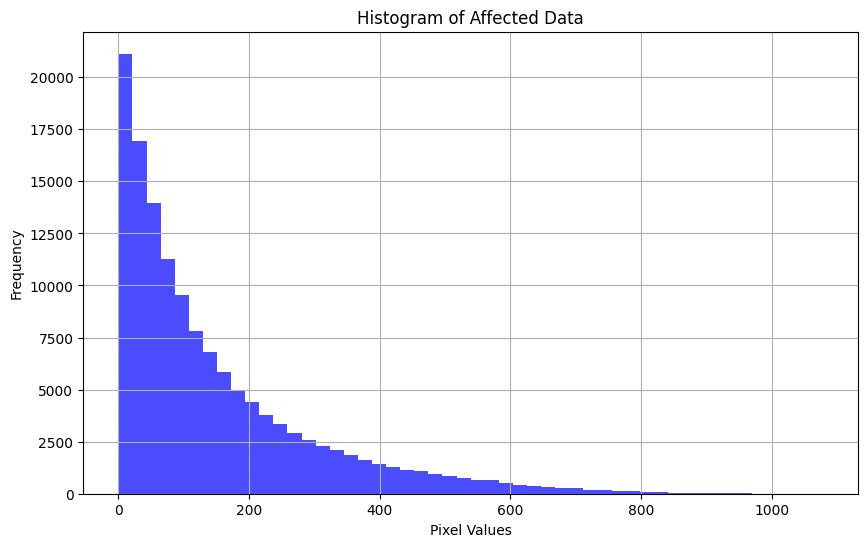

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the list to a NumPy array
data_array = np.array(affected)
flattened_data = data_array.flatten()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, color='blue', alpha=0.7,range = (0,flattened_data.max()))
plt.title('Histogram of Affected Data')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

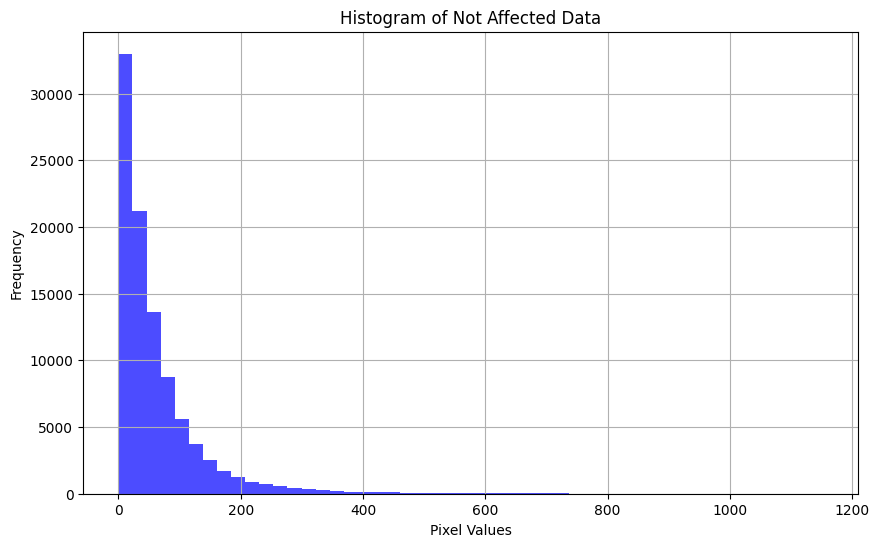

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the list to a NumPy array
data_array = np.array(not_affected)
flattened_data = data_array.flatten()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, color='blue', alpha=0.7,range = (0,flattened_data.max()))
plt.title('Histogram of Not Affected Data')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
import numpy as np

# Convert the list to a NumPy array
data_array = np.array(affected)
flattened_data = data_array.flatten()

values_above_300_affected = [value for value in flattened_data if value > 300]

count_above_300_affected = len(values_above_300_affected)

# Print the results
print("Count of Affected values above 300:", count_above_300_affected)

Count of Affected values above 300: 19971


In [9]:
import numpy as np

# Convert the list to a NumPy array
data_array = np.array(not_affected)
flattened_data = data_array.flatten()

values_above_300_na = [value for value in flattened_data if value > 300]

count_above_300_na = len(values_above_300_na)

# Print the results
print("Count of Not Affected values above 300:", count_above_300_na)

Count of Not Affected values above 300: 1846


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


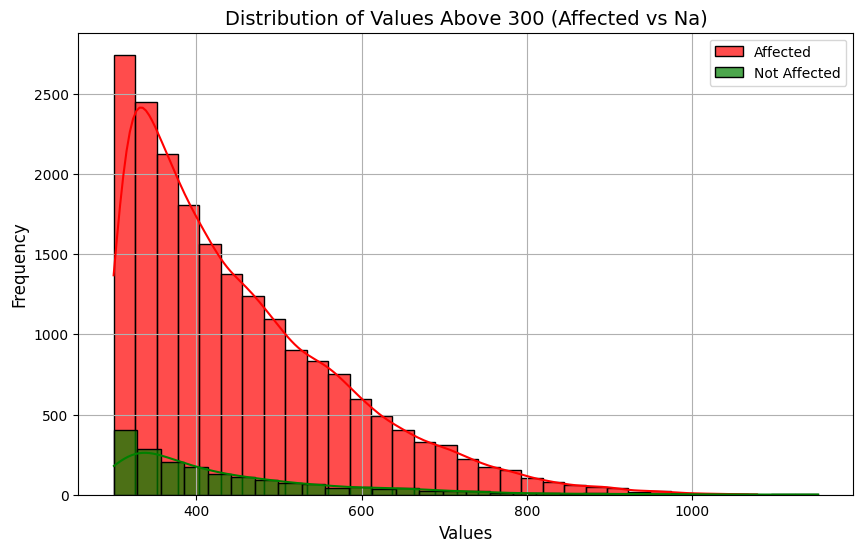

In [10]:
import seaborn as sns
# Set up the plot
plt.figure(figsize=(10, 6))

# Plot distribution for both lists with different colors
sns.histplot(values_above_300_affected, color='red', kde=True, label='Affected', alpha=0.7, bins=30)
sns.histplot(values_above_300_na, color='green', kde=True, label='Not Affected', alpha=0.7, bins=30)

# Add titles and labels
plt.title('Distribution of Values Above 300 (Affected vs Na)', fontsize=14)
plt.xlabel('Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


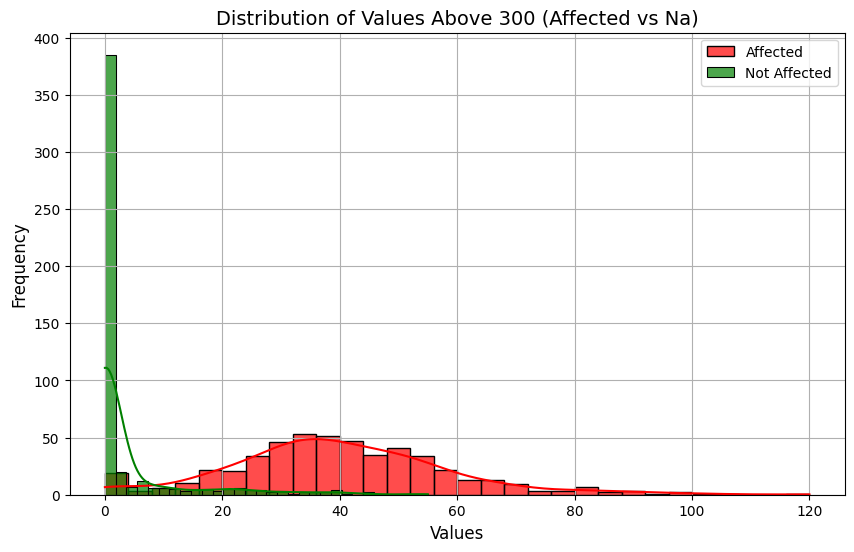

In [11]:
import seaborn as sns
# Set up the plot
plt.figure(figsize=(10, 6))

# Plot distribution for both lists with different colors
sns.histplot(flat_aff, color='red', kde=True, label='Affected', alpha=0.7, bins=30)
sns.histplot(flat_na, color='green', kde=True, label='Not Affected', alpha=0.7, bins=30)

# Add titles and labels
plt.title('Distribution of Values Above 300 (Affected vs Na)', fontsize=14)
plt.xlabel('Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

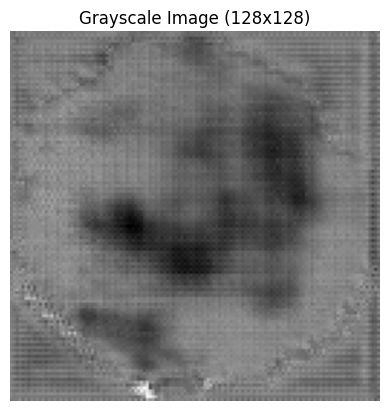

In [12]:
# Remove batch and channel dimensions for plotting
op_image = op.squeeze(0).squeeze(0)

# Plot the image
plt.imshow(op_image, cmap='gray')
plt.title("Grayscale Image (128x128)")
plt.axis('off')
plt.show()

In [13]:
mask = np.zeros((128,128,1))

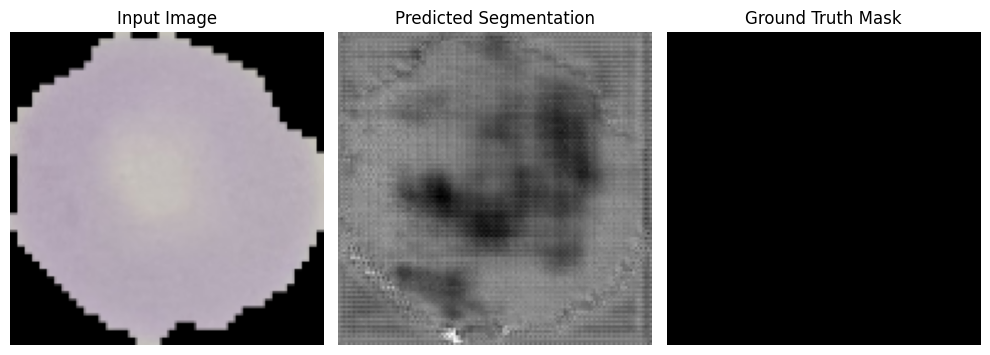

In [14]:
# Function to compare and visualize results
# Function to display images and masks
def compare_segmented(images, outputs, masks):
    fig, axes = plt.subplots(len(images), 3, figsize=(10, len(images) * 5))
    
    if len(images) == 1:
        axes = [axes]
    
    for i in range(len(images)):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        output = outputs[i][0]  # Since n_classes=1, take the first channel
        output = (output - output.min()) / (output.max() - output.min())  # Normalize to [0, 1]

        axes[i][0].imshow(image)
        axes[i][0].set_title('Input Image')
        axes[i][0].axis('off')

        axes[i][1].imshow(output, cmap='gray')
        axes[i][1].set_title('Predicted Segmentation')
        axes[i][1].axis('off')

        axes[i][2].imshow(mask, cmap='gray')
        axes[i][2].set_title('Ground Truth Mask')
        axes[i][2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualization (assuming no mask)
compare_segmented(image, op,mask)

In [15]:
import torch
import random
# Assuming model is already defined and on the correct device (e.g., CUDA or CPU)

# Function to process each image individually
def shape(image):
    model.eval()
    with torch.no_grad():
        # Pass the image through the model
        op = model(image).cpu().numpy()
        # Reshape the output to (128, 128, 1)
        #op = op.reshape(128, 128, 1)
    return op

# List to store the outputs
correct = 0
# Loop through each image in 'images' list
for i in range(100):
    image,label = dataset[random.randint(0,len(dataset))]

    # Add a batch dimension (since model expects a batch)
    image = image.unsqueeze(0).to(device)  # Image is now (1, 1, 128, 128) or (1, 3, 128, 128) for RGB
    # Call the function to process the image
    op = shape(image)
    flattened_op = op.flatten()
    # Append the result to the list
    
    prediction = len([_ for _ in flattened_op if _>300])<7
    if prediction == label:
        correct+=1
print(correct/100)

0.87


Accuracy: 0.90
Precision: 0.92
Recall (Sensitivity): 0.89
F1 Score: 0.91
Computation Time: 43.98 seconds
False Alarms (FA): 38
False Detections (FD): 58
Sensitivity: 0.89
Specificity: 0.92


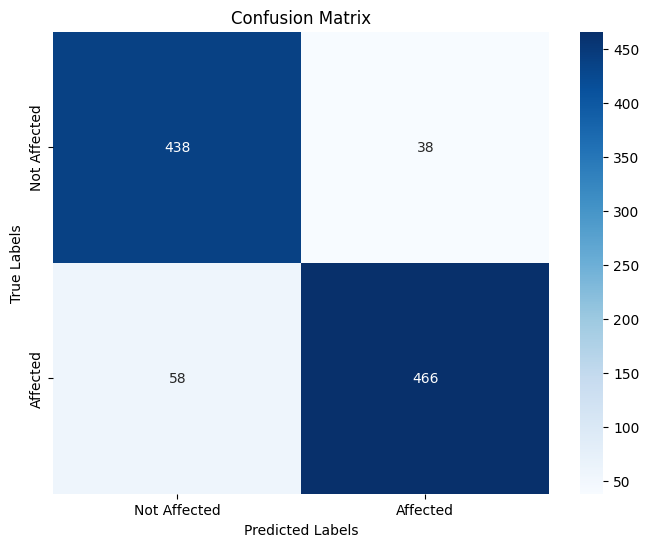


Classification Report:
              precision    recall  f1-score   support

Not Affected       0.88      0.92      0.90       476
    Affected       0.92      0.89      0.91       524

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



In [16]:
import torch
import random
import time
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Assuming 'model', 'dataset', and 'device' (CUDA or CPU) are properly defined

# Initialize variables
correct = 0
true_labels = []
predicted_labels = []

# Start computational time tracking
start_time = time.time()

# Loop through 100 randomly selected samples from the dataset
for _ in range(1000):
    image, label = dataset[random.randint(0, len(dataset) - 1)]
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Model prediction
    op = shape(image)
    flattened_op = op.flatten()

    # Prediction logic
    prediction = int(len([_ for _ in flattened_op if _ > 246]) < 24)  
    predicted_labels.append(prediction)
    true_labels.append(label)

    if prediction == label:
        correct += 1

# End computational time tracking
end_time = time.time()
computation_time = end_time - start_time

# Convert to NumPy arrays for evaluation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
TN, FP, FN, TP = conf_matrix.ravel()
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
false_alarms = FP
false_detections = FN

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Computation Time: {computation_time:.2f} seconds")
print(f"False Alarms (FA): {false_alarms}")
print(f"False Detections (FD): {false_detections}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Display Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Affected', 'Affected'], yticklabels=['Not Affected', 'Affected'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Not Affected', 'Affected']))

Accuracy: 0.89
Precision: 0.93
Recall (Sensitivity): 0.85
F1 Score: 0.89
Computation Time: 43.42 seconds
False Alarms (FA): 32
False Detections (FD): 76
Sensitivity: 0.85
Specificity: 0.94


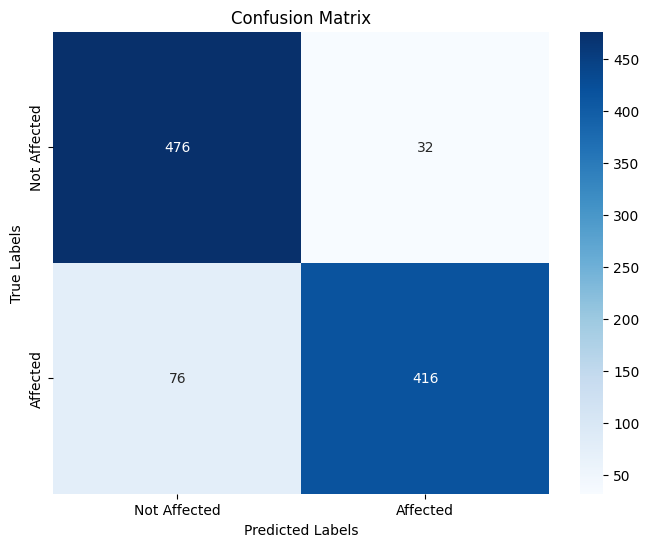


Classification Report:
              precision    recall  f1-score   support

Not Affected       0.86      0.94      0.90       508
    Affected       0.93      0.85      0.89       492

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [17]:
import torch
import random
import time
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Assuming 'model', 'dataset', and 'device' (CUDA or CPU) are properly defined

# Initialize variables
correct = 0
true_labels = []
predicted_labels = []

# Start computational time tracking
start_time = time.time()

# Loop through 100 randomly selected samples from the dataset
for _ in range(1000):
    image, label = dataset[random.randint(0, len(dataset) - 1)]
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Model prediction
    op = shape(image)
    flattened_op = op.flatten()

    # Prediction logic
    prediction = int(len([_ for _ in flattened_op if _ > 340]) < 8)  
    predicted_labels.append(prediction)
    true_labels.append(label)

    if prediction == label:
        correct += 1

# End computational time tracking
end_time = time.time()
computation_time = end_time - start_time

# Convert to NumPy arrays for evaluation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
TN, FP, FN, TP = conf_matrix.ravel()
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
false_alarms = FP
false_detections = FN

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Computation Time: {computation_time:.2f} seconds")
print(f"False Alarms (FA): {false_alarms}")
print(f"False Detections (FD): {false_detections}")
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Display Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Affected', 'Affected'], yticklabels=['Not Affected', 'Affected'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Not Affected', 'Affected']))

Threshold: 100, Accuracy: 0.65, F1 Score: 0.53, Computation Time: 4.34 seconds
Threshold: 200, Accuracy: 0.88, F1 Score: 0.85, Computation Time: 4.30 seconds
Threshold: 300, Accuracy: 0.91, F1 Score: 0.90, Computation Time: 4.35 seconds
Threshold: 400, Accuracy: 0.92, F1 Score: 0.92, Computation Time: 4.69 seconds
Threshold: 500, Accuracy: 0.80, F1 Score: 0.85, Computation Time: 4.27 seconds


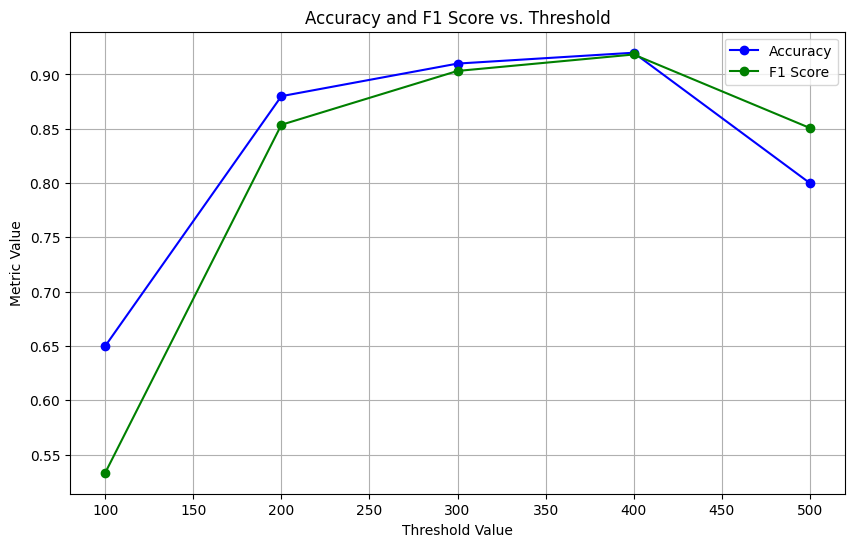

In [18]:
import torch
import random
import time
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model', 'dataset', and 'device' are properly defined

# Function to evaluate for a given threshold
def evaluate_model(threshold):
    true_labels = []
    predicted_labels = []
    start_time = time.time()
    
    for _ in range(100):
        image, label = dataset[random.randint(0, len(dataset) - 1)]
        image = image.unsqueeze(0).to(device)  # Add batch dimension

        # Model prediction
        op = shape(image)
        flattened_op = op.flatten()

        # Prediction logic for the given threshold
        prediction = int(len([_ for _ in flattened_op if _ > threshold]) < 7)
        predicted_labels.append(prediction)
        true_labels.append(label)
    
    end_time = time.time()
    computation_time = end_time - start_time
    
    # Convert to NumPy arrays for evaluation
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return accuracy, f1, computation_time

# Evaluate for different thresholds
thresholds = [100, 200, 300, 400, 500]
accuracies = []
f1_scores = []

for threshold in thresholds:
    accuracy, f1, computation_time = evaluate_model(threshold)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    print(f"Threshold: {threshold}, Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, Computation Time: {computation_time:.2f} seconds")

# Plot Accuracy and F1 Score for each threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, marker='o', label='Accuracy', color='blue')
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score', color='green')
plt.title('Accuracy and F1 Score vs. Threshold')
plt.xlabel('Threshold Value')
plt.ylabel('Metric Value')
plt.grid(True)
plt.legend()
plt.show()

Condition: 6, Accuracy: 0.88, F1 Score: 0.87, Computation Time: 43.57 seconds
Condition: 8, Accuracy: 0.87, F1 Score: 0.86, Computation Time: 43.32 seconds
Condition: 10, Accuracy: 0.90, F1 Score: 0.90, Computation Time: 43.61 seconds
Condition: 12, Accuracy: 0.89, F1 Score: 0.89, Computation Time: 42.61 seconds
Condition: 14, Accuracy: 0.93, F1 Score: 0.92, Computation Time: 43.01 seconds
Condition: 16, Accuracy: 0.90, F1 Score: 0.90, Computation Time: 42.86 seconds
Condition: 18, Accuracy: 0.90, F1 Score: 0.91, Computation Time: 42.64 seconds


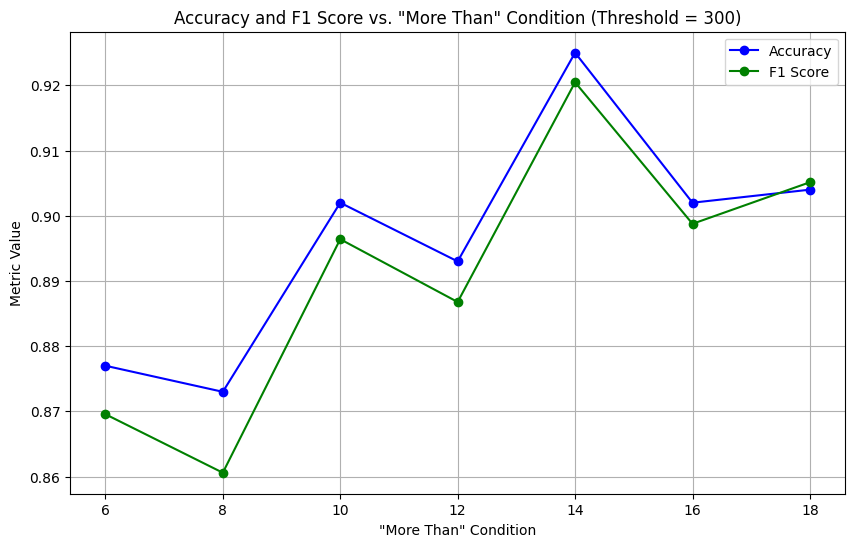

In [19]:
import torch
import random
import time
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model', 'dataset', and 'device' are properly defined

# Function to evaluate for a given "more than" condition
def evaluate_model(more_than_condition):
    true_labels = []
    predicted_labels = []
    start_time = time.time()
    
    for _ in range(1000):
        image, label = dataset[random.randint(0, len(dataset) - 1)]
        image = image.unsqueeze(0).to(device)

        # Model prediction
        op = shape(image)
        flattened_op = op.flatten()

        # Predict "affected" if the number of values > 300 is less than the condition
        prediction = int(len([_ for _ in flattened_op if _ > 300]) < more_than_condition)
        predicted_labels.append(prediction)
        true_labels.append(label)
    
    end_time = time.time()
    
    # Convert to NumPy arrays for evaluation
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return accuracy, f1, end_time - start_time

# Vary "more than" condition from 0 to 15 in steps of 2
conditions = list(range(6, 20, 2))
accuracies = []
f1_scores = []

for condition in conditions:
    accuracy, f1, computation_time = evaluate_model(condition)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    print(f"Condition: {condition}, Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, Computation Time: {computation_time:.2f} seconds")

# Plot Accuracy and F1 Score for each "more than" condition
plt.figure(figsize=(10, 6))
plt.plot(conditions, accuracies, marker='o', label='Accuracy', color='blue')
plt.plot(conditions, f1_scores, marker='o', label='F1 Score', color='green')
plt.title('Accuracy and F1 Score vs. "More Than" Condition (Threshold = 300)')
plt.xlabel('"More Than" Condition')
plt.ylabel('Metric Value')
plt.grid(True)
plt.legend()
plt.show()

|   iter    |  target   | more_t... | threshold |
-------------------------------------------------
| 1         | 0.45      | 14.98     | 760.6     |
| 2         | 0.55      | 29.28     | 478.9     |
| 3         | 0.68      | 6.241     | 124.8     |
| 4         | 0.75      | 2.323     | 692.9     |
| 5         | 0.53      | 24.04     | 566.5     |
| 6         | 0.48      | 0.8234    | 775.9     |
| 7         | 0.9       | 33.3      | 169.9     |
| 8         | 0.86      | 7.273     | 146.7     |
| 9         | 0.84      | 12.17     | 419.8     |
| 10        | 0.87      | 17.28     | 233.0     |
| 11        | 0.8       | 24.47     | 111.6     |
| 12        | 0.89      | 11.69     | 293.1     |
| 13        | 0.5       | 18.24     | 628.1     |
| 14        | 0.84      | 7.987     | 411.4     |
| 15        | 0.64      | 23.7      | 37.16     |
| 16        | 0.85      | 24.3      | 136.4     |
| 17        | 0.61      | 2.602     | 759.1     |
| 18        | 0.49      | 38.63     | 646.7     |


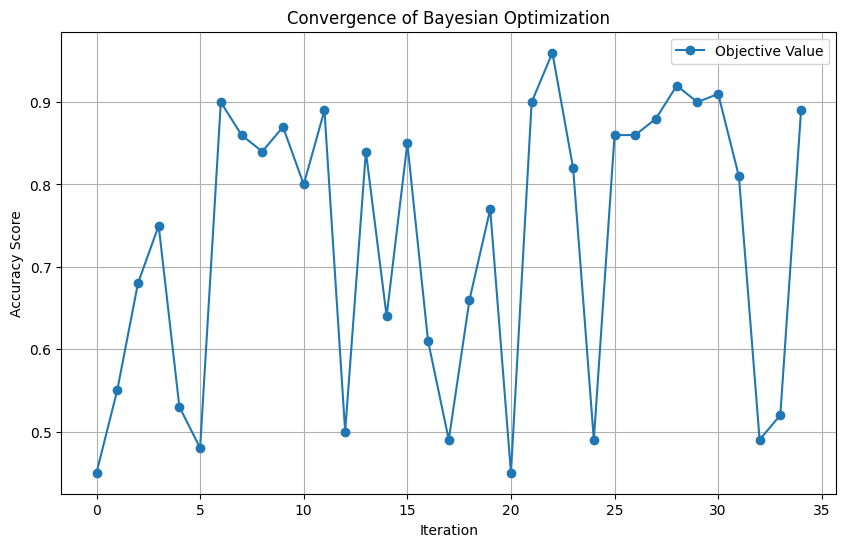

In [20]:
#!pip install bayesian-optimization  # Uncomment this line if the library is not installed

import torch
import random
import time
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

# Assuming 'model', 'dataset', and 'device' are properly defined

# Function to evaluate Accuracy and F1 Score for given parameters
def evaluate_model(threshold, more_than_condition):
    threshold = int(threshold)
    more_than_condition = int(more_than_condition)
    true_labels = []
    predicted_labels = []
    
    for _ in range(100):  # Reduced iterations for faster optimization
        image, label = dataset[random.randint(0, len(dataset) - 1)]
        image = image.unsqueeze(0).to(device)

        # Model prediction
        op = shape(image)
        flattened_op = op.flatten()

        # Prediction logic with variable threshold and more_than_condition
        prediction = int(len([_ for _ in flattened_op if _ > threshold]) < more_than_condition)
        predicted_labels.append(prediction)
        true_labels.append(label)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate Accuracy and F1 Score
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    # Return the product of Accuracy and F1 Score
    return accuracy

# Bayesian Optimization
def objective_function(threshold, more_than_condition):
    return evaluate_model(threshold, more_than_condition)

# Defining the range of parameters
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds={'threshold': (0, 800), 'more_than_condition': (0, 40)},
    random_state=42,
    verbose=2
)

# Run optimization
optimizer.maximize(init_points=20, n_iter=15)

# Best parameters and results
print("\nBest Parameters Found:", optimizer.max['params'])
print("Maximum Score (Accuracy):", optimizer.max['target'])

# Plotting the Convergence Plot
plt.figure(figsize=(10, 6))
plt.plot([res["target"] for res in optimizer.res], marker='o', label="Objective Value")
plt.title("Convergence of Bayesian Optimization")
plt.xlabel("Iteration")
plt.ylabel("Accuracy Score")
plt.grid(True)
plt.legend()
plt.show()